# Add Features to `sales_df`

The idea here is that the model is probably violating a lot of assumptions because it doesn't have enough features.  So let's add some more.

The process here will be:

 - look at the list of features
 - pick one to try to add
 - test whether it creates too much multicollinearity, and if not, add it
 - repeat

In [7]:
from src.modeling import model_evaluation, modeling
import pandas as pd
import psycopg2
import statsmodels.api as sm

In [2]:
conn = psycopg2.connect(dbname="housing_data")

In [3]:
# start with the simple model's query
q1 = """
SELECT
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    buildings.SqFtTotLiving
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [4]:
r1 = pd.read_sql_query(q1, conn)

In [6]:
modeling.transform_wfntlocation(r1)

In [8]:
X_without_constant1 = r1[[
    "wfntlocation", 
    "sqfttotliving"
    ]]
X1 = sm.add_constant(X_without_constant1)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [9]:
model_evaluation.visualize_statistical_independence(X1)

,VIF Factor,features
0,5.667952,const
1,1.006614,wfntlocation
2,1.006614,sqfttotliving


In [10]:
# add year built
q2 = """
SELECT
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    buildings.SqFtTotLiving,
    buildings.YrBuilt
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [11]:
r2 = pd.read_sql_query(q2, conn)
modeling.transform_wfntlocation(r2)
X_without_constant2 = r2[[
    "wfntlocation", 
    "sqfttotliving",
    "yrbuilt"
    ]]
X2 = sm.add_constant(X_without_constant2)
model_evaluation.visualize_statistical_independence(X2)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,VIF Factor,features
0,4395.088173,const
1,1.012537,wfntlocation
2,1.174595,sqfttotliving
3,1.168791,yrbuilt


In [12]:
# add square foot of lot
q3 = """
SELECT
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    buildings.SqFtTotLiving,
    buildings.YrBuilt,
    parcels.SqFtLot
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [13]:
r3 = pd.read_sql_query(q3, conn)
modeling.transform_wfntlocation(r3)
X_without_constant3 = r3[[
    "wfntlocation", 
    "sqfttotliving",
    "yrbuilt",
    "sqftlot"
    ]]
X3 = sm.add_constant(X_without_constant3)
model_evaluation.visualize_statistical_independence(X3)

,VIF Factor,features
0,4403.724424,const
1,1.014312,wfntlocation
2,1.190779,sqfttotliving
3,1.171005,yrbuilt
4,1.016734,sqftlot


In [16]:
# what the heck, add several at once.  grabbing all of them that seem like reasonable
# numeric or true/false inputs from sales + parcels
q4 = """
SELECT
    -- from sales table
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    -- from parcels table
    parcels.SqFtLot,
    parcels.PcntUnusable,
    parcels.LotDepthFactor,
    parcels.AirportNoise,
    parcels.NbrBldgSites,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    buildings.SqFtTotLiving,
    buildings.YrBuilt
    
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [18]:
r4 = pd.read_sql_query(q4, conn)
modeling.transform_wfntlocation(r4)
X_without_constant4 = r4[[
    "sqftlot",
    "pcntunusable",
    "lotdepthfactor",
    "airportnoise",
    "nbrbldgsites",
    "wfntlocation", 
    "sqfttotliving",
    "yrbuilt"
    ]]
X4 = sm.add_constant(X_without_constant4)
model_evaluation.visualize_statistical_independence(X4)

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,4403.788725,const
1,1.025721,sqftlot
2,1.006355,pcntunusable
3,1.020022,lotdepthfactor
4,NaN,airportnoise
5,1.005961,nbrbldgsites
6,1.034625,wfntlocation
7,1.193755,sqfttotliving
8,1.171014,yrbuilt


Ok the NaN concerns me so I'm going to remove Airport Noise

But it looks like I'm good to add numeric features from `buildings`

In [19]:
# adding so many features from buildings, that hopefully I start to see high multicollinearity
# scores, so I know this tool is working!

q5 = """
SELECT
    -- from sales table
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    -- from parcels table
    parcels.SqFtLot,
    parcels.PcntUnusable,
    parcels.LotDepthFactor,
    parcels.AirportNoise,
    parcels.NbrBldgSites,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    -- from buildings table
    buildings.Stories,
    buildings.sqft1stfloor,
    buildings.sqfthalffloor,
    buildings.sqft2ndfloor,
    buildings.sqftupperfloor,
    buildings.sqftunfinfull,
    buildings.sqftunfinhalf,
    buildings.SqFtTotLiving,
    buildings.sqfttotbasement,
    buildings.sqftfinbasement,
    buildings.sqftgaragebasement,
    buildings.sqftgarageattached,
    buildings.sqftopenporch,
    buildings.sqftenclosedporch,
    buildings.sqftdeck,
    buildings.YrBuilt
    
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [20]:
r5 = pd.read_sql_query(q5, conn)
modeling.transform_wfntlocation(r5)
X_without_constant5 = r5[[
    "sqftlot",
    "pcntunusable",
    "lotdepthfactor",
    "airportnoise",
    "nbrbldgsites",
    "wfntlocation",
    "stories",
    "sqft1stfloor",
    "sqfthalffloor",
    "sqft2ndfloor",
    "sqftupperfloor",
    "sqftunfinfull",
    "sqftunfinhalf",
    "sqfttotliving",
    "sqfttotbasement",
    "sqftfinbasement",
    "sqftgaragebasement",
    "sqftgarageattached",
    "sqftopenporch",
    "sqftenclosedporch",
    "sqftdeck",
    "yrbuilt"
    ]]
X5 = sm.add_constant(X_without_constant5)
model_evaluation.visualize_statistical_independence(X5)

,VIF Factor,features
0,8738.292646,const
1,1.079659,sqftlot
2,1.007068,pcntunusable
3,1.021016,lotdepthfactor
4,NaN,airportnoise
5,1.019963,nbrbldgsites
6,1.043021,wfntlocation
7,5.399923,stories
8,8752.449523,sqft1stfloor
9,847.287789,sqfthalffloor


Phew, this is actually doing something!  Let's remove some features

In [21]:
# remove "basement" features other than "sqfttotbasement"
# remove "sqft1stfloor" and "sqft2ndfloor" so we can potentially keep "sqfttotliving"
# remove "airportnoise" because we're not sure what it's doing
q6 = """
SELECT
    -- from sales table
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    -- from parcels table
    parcels.SqFtLot,
    parcels.PcntUnusable,
    parcels.LotDepthFactor,
    parcels.NbrBldgSites,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    -- from buildings table
    buildings.Stories,
    buildings.sqfthalffloor,
    buildings.sqftupperfloor,
    buildings.sqftunfinfull,
    buildings.sqftunfinhalf,
    buildings.SqFtTotLiving,
    buildings.sqfttotbasement,
    buildings.sqftgarageattached,
    buildings.sqftopenporch,
    buildings.sqftenclosedporch,
    buildings.sqftdeck,
    buildings.YrBuilt
    
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [22]:
r6 = pd.read_sql_query(q6, conn)
modeling.transform_wfntlocation(r6)
X_without_constant6 = r6[[
    "sqftlot",
    "pcntunusable",
    "lotdepthfactor",
    "nbrbldgsites",
    "wfntlocation",
    "stories",
    "sqfthalffloor",
    "sqftupperfloor",
    "sqftunfinfull",
    "sqftunfinhalf",
    "sqfttotliving",
    "sqfttotbasement",
    "sqftgarageattached",
    "sqftopenporch",
    "sqftenclosedporch",
    "sqftdeck",
    "yrbuilt"
    ]]
X6 = sm.add_constant(X_without_constant6)
model_evaluation.visualize_statistical_independence(X6)

,VIF Factor,features
0,7222.056470,const
1,1.053264,sqftlot
2,1.006986,pcntunusable
3,1.020965,lotdepthfactor
4,1.015966,nbrbldgsites
5,1.037243,wfntlocation
6,2.246024,stories
7,1.215048,sqfthalffloor
8,1.302894,sqftupperfloor
9,1.006592,sqftunfinfull


Ok wow, all of those are fine?  Let's keep adding then

In [25]:
# add the rest of the true numeric features from buildings
q7 = """
SELECT
    -- from sales table
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    -- from parcels table
    parcels.SqFtLot,
    parcels.PcntUnusable,
    parcels.LotDepthFactor,
    parcels.NbrBldgSites,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    -- from buildings table
    buildings.Stories,
    buildings.sqfthalffloor,
    buildings.sqftupperfloor,
    buildings.sqftunfinfull,
    buildings.sqftunfinhalf,
    buildings.SqFtTotLiving,
    buildings.sqfttotbasement,
    buildings.sqftgarageattached,
    buildings.sqftopenporch,
    buildings.sqftenclosedporch,
    buildings.sqftdeck,
    buildings.brickstone,
    buildings.bedrooms,
    buildings.bathhalfcount,
    buildings.bath3qtrcount,
    buildings.bathfullcount,
    buildings.fpsinglestory,
    buildings.fpmultistory,
    buildings.fpfreestanding,
    buildings.fpadditional,
    buildings.YrBuilt,
    buildings.yrrenovated,
    buildings.pcntcomplete,
    buildings.pcntnetcondition
    
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [26]:
r7 = pd.read_sql_query(q7, conn)
modeling.transform_wfntlocation(r7)
X_without_constant7 = r7[[
    "sqftlot",
    "pcntunusable",
    "lotdepthfactor",
    "nbrbldgsites",
    "wfntlocation",
    "stories",
    "sqfthalffloor",
    "sqftupperfloor",
    "sqftunfinfull",
    "sqftunfinhalf",
    "sqfttotliving",
    "sqfttotbasement",
    "sqftgarageattached",
    "sqftopenporch",
    "sqftenclosedporch",
    "sqftdeck",
    "brickstone",
    "bedrooms",
    "bathhalfcount",
    "bath3qtrcount",
    "bathfullcount",
    "fpsinglestory",
    "fpmultistory",
    "fpfreestanding",
    "fpadditional",
    "yrbuilt",
    "yrrenovated",
    "pcntcomplete",
    "pcntnetcondition"
    ]]
X7 = sm.add_constant(X_without_constant7)
model_evaluation.visualize_statistical_independence(X7)

,VIF Factor,features
0,9173.032600,const
1,1.071085,sqftlot
2,1.007657,pcntunusable
3,1.021322,lotdepthfactor
4,1.030046,nbrbldgsites
5,1.060912,wfntlocation
6,2.738111,stories
7,1.238989,sqfthalffloor
8,1.351920,sqftupperfloor
9,1.007256,sqftunfinfull


Wow, I really didn't think this many features could be this independent of each other

Let's run a model evaluation!

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     481.5
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:59:03   Log-Likelihood:            -4.4791e+05
No. Observations:               30272   AIC:                         8.959e+05
Df Residuals:                   30242   BIC:                         8.961e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.177e+06   3.55

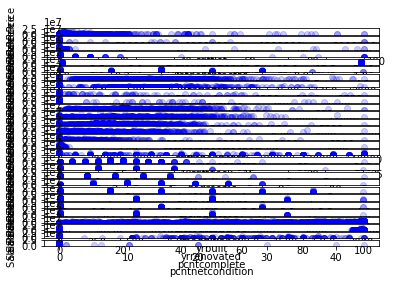

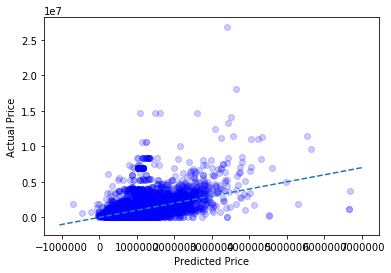

('Violates the linearity assumption according to the rainbow test', 6.0838854146858595e-33)

Performing Independence Checks

     VIF Factor            features
0   9173.032600               const
1      1.071085             sqftlot
2      1.007657        pcntunusable
3      1.021322      lotdepthfactor
4      1.030046        nbrbldgsites
5      1.060912        wfntlocation
6      2.738111             stories
7      1.238989       sqfthalffloor
8      1.351920      sqftupperfloor
9      1.007256       sqftunfinfull
10     1.016994       sqftunfinhalf
11     4.814685       sqfttotliving
12     2.332170     sqfttotbasement
13     2.101336  sqftgarageattached
14     1.384398       sqftopenporch
15     1.015071   sqftenclosedporch
16     1.012899            sqftdeck
17     1.080187          brickstone
18     1.853194            bedrooms
19     1.592335       bathhalfcount
20     2.099005       bath3qtrcount
21     3.010891       bathfullcount
22     1.805697       fpsinglestory
23     2.12

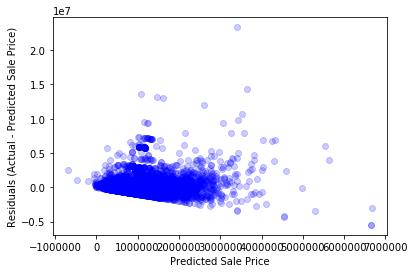

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 1.5449365622161197e-274)

Performing Normality Checks



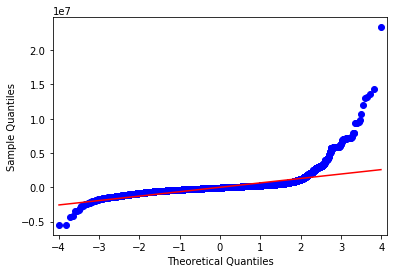

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [28]:
y7 = r7["saleprice"]
modeling.fit_and_evaluate_model_from_inputs(y7, X_without_constant7, X7)

Let's remove everything with too high of a p-value

In [29]:
# removing "pcntunusable", "nbrbldgsites", "sqfthalffloor", "sqftunfinfull"
# "sqftdeck", "bathhalfcount", "fpmultistory", "fpadditional"

# leaving in "yrrenovated" for now
q8 = """
SELECT
    -- from sales table
    CONCAT(sales.Major, sales.Minor) AS PIN,        -- parcel id number
    sales.SalePrice,
    sales.DocumentDate,
    -- from parcels table
    parcels.SqFtLot,
    parcels.LotDepthFactor,
    CASE
        WHEN parcels.WfntLocation > 0                -- 1-9 indicate particular bodies of water
            THEN TRUE
        ELSE                                         -- I infer that 0 means no waterfront
            FALSE
    END as WfntLocation,
    -- from buildings table
    buildings.Stories,
    buildings.sqftupperfloor,
    buildings.sqftunfinhalf,
    buildings.SqFtTotLiving,
    buildings.sqfttotbasement,
    buildings.sqftgarageattached,
    buildings.sqftopenporch,
    buildings.sqftenclosedporch,
    buildings.brickstone,
    buildings.bedrooms,
    buildings.bath3qtrcount,
    buildings.bathfullcount,
    buildings.fpsinglestory,
    buildings.fpfreestanding,
    buildings.YrBuilt,
    buildings.yrrenovated,
    buildings.pcntcomplete,
    buildings.pcntnetcondition
    
FROM sales                                           -- start the join with sales bc sale price is target
    INNER JOIN parcels ON (                          -- parcel major + minor is the unique identifier
            parcels.Major = sales.Major              -- (parcels are the things being sold in the sales)
        AND parcels.Minor = sales.Minor
    )
    INNER JOIN buildings ON (                        -- building belongs to one parcel
            buildings.Major = parcels.Major          -- parcel can have many buildings (unclear how often)
        AND buildings.Minor = parcels.Minor
    )
WHERE (
        date_part('year', sales.DocumentDate) = 2018 -- 2018 is the specified year
    AND sales.SalePrice > 0                          -- assume that sale price of 0 is bad data
)
ORDER BY sales.DocumentDate;

"""

In [30]:
r8 = pd.read_sql_query(q8, conn)
modeling.transform_wfntlocation(r8)
X_without_constant8 = r8[[
    "sqftlot",
    "lotdepthfactor",
    "wfntlocation",
    "stories",
    "sqftupperfloor",
    "sqftunfinhalf",
    "sqfttotliving",
    "sqfttotbasement",
    "sqftgarageattached",
    "sqftopenporch",
    "sqftenclosedporch",
    "brickstone",
    "bedrooms",
    "bath3qtrcount",
    "bathfullcount",
    "fpsinglestory",
    "fpfreestanding",
    "yrbuilt",
    "yrrenovated",
    "pcntcomplete",
    "pcntnetcondition"
    ]]
X8 = sm.add_constant(X_without_constant8)
y8 = r8["saleprice"]

//anaconda3/envs/mod2-project-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     664.9
Date:                Sat, 30 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:07:52   Log-Likelihood:            -4.4791e+05
No. Observations:               30272   AIC:                         8.959e+05
Df Residuals:                   30250   BIC:                         8.960e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.104e+06   3.22

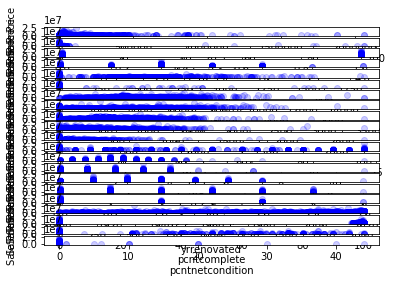

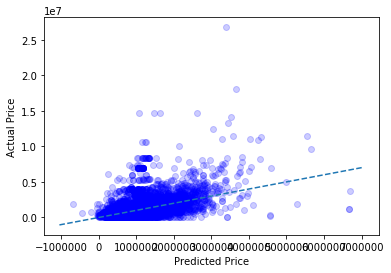

('Violates the linearity assumption according to the rainbow test', 1.6702998182554026e-32)

Performing Independence Checks

     VIF Factor            features
0   7533.172340               const
1      1.058586             sqftlot
2      1.020956      lotdepthfactor
3      1.058976        wfntlocation
4      2.249561             stories
5      1.305100      sqftupperfloor
6      1.002479       sqftunfinhalf
7      4.429232       sqfttotliving
8      2.146082     sqfttotbasement
9      2.002386  sqftgarageattached
10     1.360187       sqftopenporch
11     1.013487   sqftenclosedporch
12     1.063559          brickstone
13     1.828695            bedrooms
14     1.840339       bath3qtrcount
15     2.748378       bathfullcount
16     1.314755       fpsinglestory
17     1.059225      fpfreestanding
18     2.054212             yrbuilt
19     1.116735         yrrenovated
20     1.034763        pcntcomplete
21     1.000737    pcntnetcondition
('The following features violate the independen

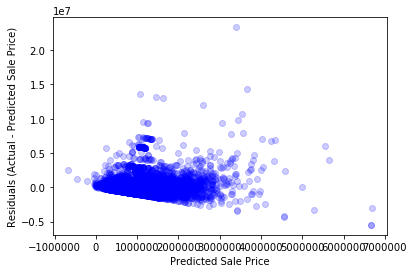

('Violates the homoscedasticity assumption according to the Breusch-Pagan test', 2.1939683905881027e-278)

Performing Normality Checks



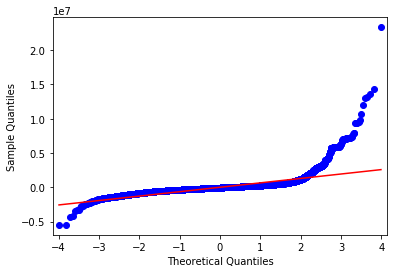

('Violates the normality assumption according to the Kolmogorov-Smirnov test', 0.0)


In [31]:
modeling.fit_and_evaluate_model_from_inputs(y8, X_without_constant8, X8)